In [1]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import warnings
warnings.filterwarnings('ignore')
import pysensors as ps
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from IPython.display import HTML
HTML("""
<style>
.output {
    display: flex;
    text-align: center;
    vertical-align: center;
    margins:auto
}
</style>
""")

## Load data for Opti-TWIST prototype:

In [3]:
import pandas as pd
df = pd.read_csv('~/projects/Sparse_Sensing_in_NDTs_LDRD/data/0_raw/004_BB_7Power_7BC/650_420.csv')
df

,Temperature (K),Velocity[i] (m/s),Velocity[j] (m/s),X (m),Y (m),Z (m)
0,526.648511,1.79769313486232e+308,1.79769313486232e+308,0.002953,-0.017654,0
1,526.645400,1.79769313486232e+308,1.79769313486232e+308,0.002982,-0.017977,0
2,526.669124,1.79769313486232e+308,1.79769313486232e+308,0.002863,-0.017775,0
3,526.738401,1.79769313486232e+308,1.79769313486232e+308,0.002503,-0.017575,0
4,526.668918,1.79769313486232e+308,1.79769313486232e+308,0.002881,-0.018116,0
...,...,...,...,...,...,...
40505,420.000000,1.79769313486232e+308,1.79769313486232e+308,0.044450,-0.237005,0
40506,420.000000,1.79769313486232e+308,1.79769313486232e+308,0.044450,-0.239735,0
40507,420.000000,1.79769313486232e+308,1.79769313486232e+308,0.044450,-0.242478,0
40508,420.000000,1.79769313486232e+308,1.79769313486232e+308,0.044450,-0.245220,0


## Temperature profile of Opti-TWIST prototype:

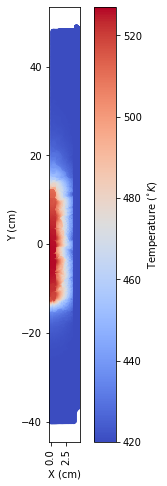

In [4]:
X,Y = df['X (m)'], df['Y (m)']
fig = plt.figure(figsize=(5,8))
plt.scatter(X*100,Y*100, s=10, c=df['Temperature (K)'],cmap=plt.cm.coolwarm)
plt.xlabel('X (cm)')
plt.tick_params(axis='x', labelrotation = 90)
plt.ylabel('Y (cm)')
cbar = plt.colorbar()
cbar.set_label('Temperature ($^{\circ}K$)')
axes=plt.gca()
axes.set_aspect(0.7)

## Data preprocessing, Wrangling, Cleansing and Scraping

In [5]:
Responses = ['Temperature (K)','Velocity[i] (m/s)','Velocity[j] (m/s)']
RoI = Responses[0]
filename = "~/projects/Sparse_Sensing_in_NDTs_LDRD/data/0_raw/004_BB_7Power_7BC/"
data = np.zeros((40510,49))
counter = -1
for j,i in enumerate(np.arange(350,700,50)):
    for l,k in enumerate(np.arange(240,450,30)):
        df = pd.read_csv(filename + str(i) + '_' + str(k) + '.csv')
        counter += 1
        if i == 650 and k == 420:
            print(counter)
        for n in range(3):     
            df[Responses[n]].replace(to_replace='1.79769313486232e+308', value=0.0, inplace=True)
        data[:,counter] = df[RoI]

48


In [6]:
data = data.T
print(np.shape(data))
df

(49, 40510)


,Temperature (K),Velocity[i] (m/s),Velocity[j] (m/s),X (m),Y (m),Z (m)
0,526.648511,0.0,0.0,0.002953,-0.017654,0
1,526.645400,0.0,0.0,0.002982,-0.017977,0
2,526.669124,0.0,0.0,0.002863,-0.017775,0
3,526.738401,0.0,0.0,0.002503,-0.017575,0
4,526.668918,0.0,0.0,0.002881,-0.018116,0
...,...,...,...,...,...,...
40505,420.000000,0.0,0.0,0.044450,-0.237005,0
40506,420.000000,0.0,0.0,0.044450,-0.239735,0
40507,420.000000,0.0,0.0,0.044450,-0.242478,0
40508,420.000000,0.0,0.0,0.044450,-0.245220,0


## Find all sensor locations using built in QR optimizer

In [7]:
n_sensors = 8
n_modes = 8
basis = ps.basis.SVD(n_basis_modes=n_modes)
optimizer  = ps.optimizers.QR()
model = ps.SSPOR(basis=basis, optimizer=optimizer, n_sensors=n_sensors)
model.fit(data)
all_sensors = model.get_all_sensors()
sensors = model.get_selected_sensors()

## Sensor locations on the grid:

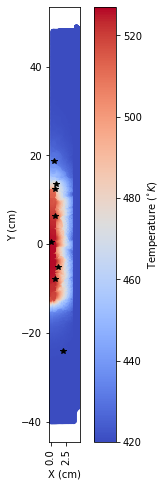

In [8]:
yUnconstrained = df['Y (m)'][sensors]
xUnconstrained = df['X (m)'][sensors]

X,Y = df['X (m)'], df['Y (m)']
fig = plt.figure(figsize=(5,8))
plt.scatter(X*100,Y*100, s=10, c=df['Temperature (K)'],cmap=plt.cm.coolwarm)
plt.xlabel('X (cm)')
plt.tick_params(axis='x', labelrotation = 90)
plt.ylabel('Y (cm)')
cbar = plt.colorbar()
cbar.set_label('Temperature ($^{\circ}K$)')
plt.plot(xUnconstrained*100,yUnconstrained*100,'*k')
axes=plt.gca()
axes.set_aspect(0.7)

In [9]:
xUnc, yUnc = ps.utils._constraints.get_coordinates_from_indices(sensors,df, Y_axis = 'Y (m)', X_axis = 'X (m)', Field = 'Temperature (K)')

### Functional constraints:

Suppose the user wants to constrain a circular area centered at x = 0.025 m, y = 0 m with a radius (r = 0.02 m).
The user can do see by initiating an instance of the class Circle which has functionalities such as :
- Plotting
- Plotting all possioble sensor locations
- Plotting the constraint on data
- Obtaining indices of sensors within/outside the constrained circle
- A dataframe of sensor indices along with their coordinate locations on the grid
- Plotting the sensors on the grid
- Annotating with the sensor number


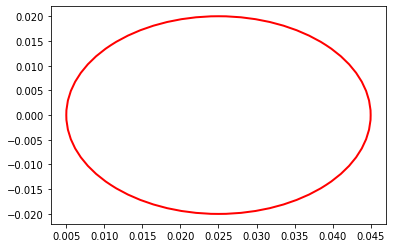

In [10]:
circle = ps.utils._constraints.Circle(center_x = 0.025, center_y = 0, radius = 0.02, loc = 'in', data = df, Y_axis = 'Y (m)', X_axis = 'X (m)', Field = 'Temperature (K)') #Plotting the constrained circle 
circle.draw_constraint() ###Plotting just the constraint

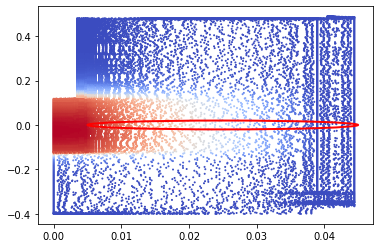

In [11]:
circle.plot_constraint_on_data(plot_type='contour_map') ##Plotting the constraint on the data

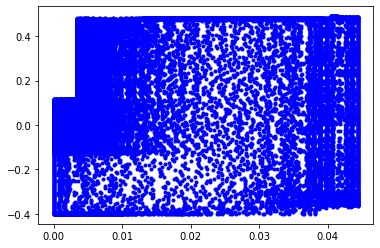

In [12]:
circle.plot_grid(all_sensors=all_sensors)

### Obtaining constrained indices :

In [13]:
const_idx, rank = circle.get_constraint_indices(all_sensors = all_sensors, info=df)  

### Using these constrained indices with pysensors GQR optimizer:

In [14]:
# Define the number of constrained sensors allowed (s)
n_const_sensors = 1

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_circle = ps.optimizers.GQR()
opt_exact_kws={'idx_constrained':const_idx,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sensors,
         'all_sensors':all_sensors,
         'constraint_option':"exact_n"}
basis_exact = ps.basis.SVD(n_basis_modes=n_sensors)

### List of selected sensors 

In [15]:
# Initialize and fit the model
model_exact = ps.SSPOR(basis = basis_exact, optimizer = optimizer_circle, n_sensors = n_sensors)
model_exact.fit(data,**opt_exact_kws)

# sensor locations based on columns of the data matrix
top_sensors_exact = model_exact.get_selected_sensors()

# sensor locations based on pixels of the image
xCircle, yCircle = ps.utils._constraints.get_coordinates_from_indices(top_sensors_exact,df,Y_axis = 'Y (m)', X_axis = 'X (m)', Field = 'Temperature (K)' )

print('The list of sensors selected is: {}'.format(top_sensors_exact))

The list of sensors selected is: [15658 18378 29993 16573 31414 40090 21456 37537]


### List of indices of sensors selected along with their coordinate locations on the grid

In [16]:
data_sens_circle = circle.sensors_dataframe(sensors = top_sensors_exact)
data_sens_circle

,Sensor ID,SensorX,sensorY
0,15658.0,0.008200,0.136713
1,18378.0,0.006977,0.063449
2,29993.0,0.011413,-0.051947
3,16573.0,0.007676,0.124104
4,31414.0,0.006206,-0.079055
5,40090.0,0.019092,-0.241529
6,21456.0,0.004899,0.187096
7,37537.0,0.005085,-0.001238


### Plotting and annotating (Numbered list of) the sensors

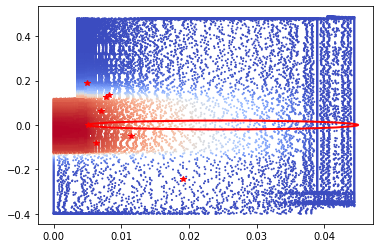

In [17]:
circle.plot_constraint_on_data(plot_type='contour_map')
circle.plot_selected_sensors(sensors = top_sensors_exact)
circle.annotate_sensors(sensors = top_sensors_exact)

### Trying out a custom parabolic constraint: ( Now what if the user has provided a python file with the required constraints)

##### Here the parabola is centered at (h,k) = (0.025,0.00)
##### The equation used is $y = a(x-h)^2 -k$ where a = 100
##### A line drawn at y = 0.2 closes the parabola and the constrained region is bound by the parabola and the line.

#### The user can initiate an instance of the class UserDefinedConstraints and use functionalities like plotting, annotating, creating a dataframe 

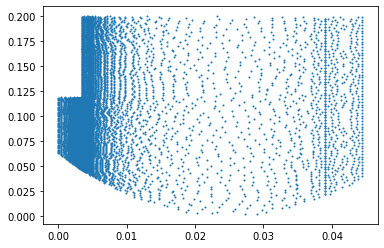

In [18]:
const5 = 'twistParabolicConstraint.py' ### Python file with the required constraints
user_const_instance = ps.utils._constraints.UserDefinedConstraints(all_sensors, file = const5, data = df, Y_axis = 'Y (m)', X_axis = 'X (m)', Field = 'Temperature (K)' )
idx, rank = user_const_instance.constraint()
user_const_instance.draw_constraint() ## plot the user defined constraint just by itself

### Using these constrained indices with pysensors GQR optimizer:

In [19]:
# Define the number of constrained sensors allowed (s)
n_const_sensors = 0

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_user = ps.optimizers.GQR()
opt_user_kws={'idx_constrained':idx,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sensors,
         'all_sensors':all_sensors,
         'constraint_option':"exact_n"}
basis_user = ps.basis.SVD(n_basis_modes=n_sensors)

### List of selected sensors 

In [20]:
# Initialize and fit the model
model_user = ps.SSPOR(basis = basis_user, optimizer = optimizer_user, n_sensors = n_sensors)
model_user.fit(data,**opt_user_kws)

# sensor locations based on columns of the data matrix
top_sensors_user = model_user.get_selected_sensors()

# sensor locations based on pixels of the image
# sensor locations based on pixels of the image
xCircle, yCircle = ps.utils._constraints.get_coordinates_from_indices(top_sensors_exact,df,Y_axis = 'Y (m)', X_axis = 'X (m)', Field = 'Temperature (K)' )

print('The list of sensors selected is: {}'.format(top_sensors_exact))

The list of sensors selected is: [15658 18378 29993 16573 31414 40090 21456 37537]


### List of indices of sensors selected along with their coordinate locations on the grid

In [21]:
data_sens_user = user_const_instance.sensors_dataframe(sensors = top_sensors_user)
data_sens_user

,Sensor ID,SensorX,sensorY
0,31414.0,0.006206,-0.079055
1,30106.0,0.011132,-0.040648
2,19000.0,0.006517,0.033655
3,36479.0,0.010434,-0.230693
4,35723.0,0.006281,-0.377601
5,2620.0,0.000124,-0.009141
6,21714.0,0.004854,0.200180
7,16890.0,0.000154,0.061574


### The sensor locations plotted on the grid along with the constrained region

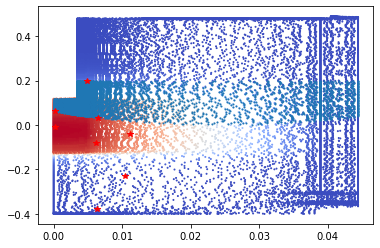

In [22]:
user_const_instance.plot_constraint_on_data(plot_type='contour_map') 
user_const_instance.plot_selected_sensors(sensors = top_sensors_user)
user_const_instance.annotate_sensors(sensors = top_sensors_user)

### Now lets look at how to do the above with the constraint shapes defined in the class:

#### Initiating a class instance of the shape parabola : 

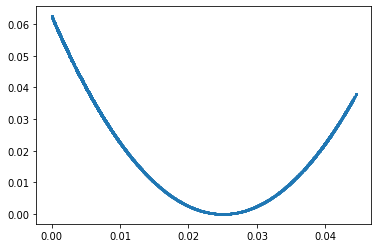

In [23]:
parabola = ps.utils._constraints.Parabola(h = 0.025, k = 0, a = 100, loc = 'in', data = df, Y_axis = 'Y (m)', X_axis = 'X (m)', Field = 'Temperature (K)') #Plotting the constrained circle 
parabola.draw_constraint() ###Plotting just the constraint

#### Initiating a class instance of the shape line : 

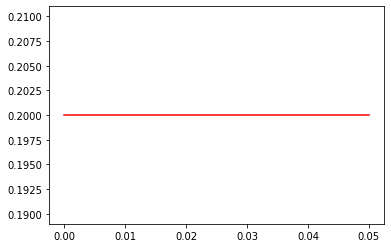

In [24]:
line1 = ps.utils._constraints.Line(x1 = 0, x2 = 0.05, y1 = 0.2, y2 = 0.2, data = df, Y_axis = 'Y (m)', X_axis = 'X (m)', Field = 'Temperature (K)') #Plotting the constrained line  ##expect a tuple of (x,y)
line1.draw_constraint() ## plotting just the constraint

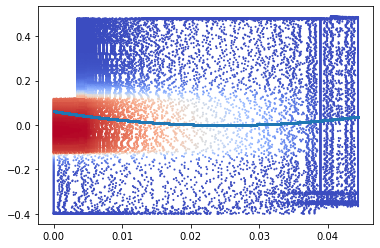

In [25]:
parabola.plot_constraint_on_data(plot_type='contour_map') ## Plotting the constraint on the data

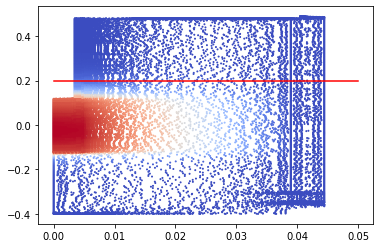

In [26]:
line1.plot_constraint_on_data(plot_type='contour_map') ## Plotting the constraint on the data

#### Locating constrained indices of the parabola

In [27]:
const_idx_parabola, rank_parabola = parabola.get_constraint_indices(all_sensors=all_sensors, info = df)

#### Locating constrained indices of the line

In [28]:
const_idx1, rank1 = line1.get_constraint_indices(all_sensors=all_sensors, info = df)

#### Finding the common constrained indices between them :

In [29]:
Common_constrained_idx = np.intersect1d(const_idx_parabola, const_idx1)

### Using the common constrained indices with the GQR optimizer in pysensors

In [30]:
# Define the number of constrained sensors allowed (s)
n_const_sen_parabola = 0

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_parabola = ps.optimizers.GQR()
opt_parabola_kws={'idx_constrained': Common_constrained_idx,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sen_parabola,
         'all_sensors':all_sensors,
         'constraint_option':"exact_n"}
basis_parabola = ps.basis.SVD(n_basis_modes=n_sensors)

In [31]:
# Initialize and fit the model
model_parabola = ps.SSPOR(basis = basis_parabola, optimizer = optimizer_parabola, n_sensors = n_sensors)
model_parabola.fit(data,**opt_parabola_kws)

# sensor locations based on columns of the data matrix
top_sensors_parabola = model_parabola.get_selected_sensors()

# sensor locations based on pixels of the image
xPara, yPara = ps.utils._constraints.get_coordinates_from_indices(top_sensors_parabola,df,Y_axis = 'Y (m)', X_axis = 'X (m)', Field = 'Temperature (K)' )

print('The list of sensors selected is: {}'.format(top_sensors_parabola))

The list of sensors selected is: [31414 30106 19000 36479 35723  2620 21714 16890]


In [32]:
data_sens_parabola = parabola.sensors_dataframe(sensors = top_sensors_parabola)
data_sens_parabola

,Sensor ID,SensorX,sensorY
0,31414.0,0.006206,-0.079055
1,30106.0,0.011132,-0.040648
2,19000.0,0.006517,0.033655
3,36479.0,0.010434,-0.230693
4,35723.0,0.006281,-0.377601
5,2620.0,0.000124,-0.009141
6,21714.0,0.004854,0.200180
7,16890.0,0.000154,0.061574


### Sensor locations: 

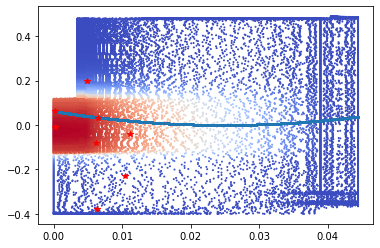

In [33]:
parabola.plot_constraint_on_data(plot_type='contour_map') ## Plotting the constraint on the data!
parabola.plot_selected_sensors(sensors = top_sensors_parabola)
parabola.annotate_sensors(sensors = top_sensors_parabola)

### Lets compare the results we get from both methods: 

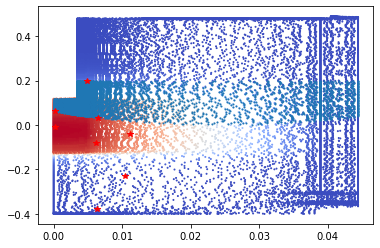

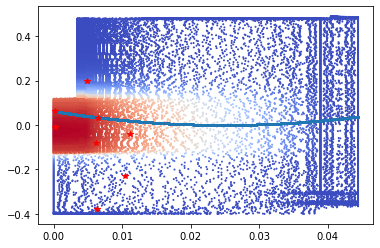

In [34]:
user_const_instance.plot_constraint_on_data(plot_type='contour_map') 
user_const_instance.plot_selected_sensors(sensors = top_sensors_user)
user_const_instance.annotate_sensors(sensors = top_sensors_user)

parabola.plot_constraint_on_data(plot_type='contour_map') ## Plotting the constraint on the data!
parabola.plot_selected_sensors(sensors = top_sensors_parabola)
parabola.annotate_sensors(sensors = top_sensors_parabola)

### Now let us consider an example where the user inputs the equation that they are considering as a constraint in a string 

For example the equation of a parabola is :
a(x-h)^2 - (y- k)

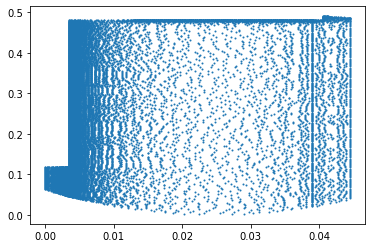

In [35]:
const5_stg = '(100*((x-0.025)**2)) > y' ### Python string with the required equation for a parabola
user_const_stg_instance = ps.utils._constraints.UserDefinedConstraints(all_sensors, data = df, Y_axis = 'Y (m)', X_axis = 'X (m)', Field = 'Temperature (K)' , equation = const5_stg)
idx_stg, rank_stg = user_const_stg_instance.constraint()
user_const_stg_instance.draw_constraint() ## plot the user defined constraint just by itself

And the equation of the line is :
y - 0.2 = 0

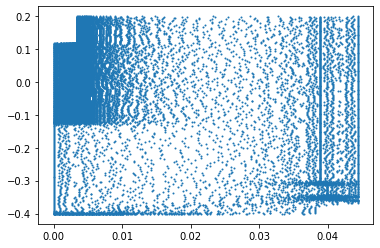

In [36]:
const5_line_stg = 'y > 0.2' ### Python string with the required equation for a parabola
user_const_stg_line_instance = ps.utils._constraints.UserDefinedConstraints(all_sensors, data = df, Y_axis = 'Y (m)', X_axis = 'X (m)', Field = 'Temperature (K)' , equation = const5_line_stg)
idx_stg_line, rank_stg_line = user_const_stg_line_instance.constraint()
user_const_stg_line_instance.draw_constraint() ## plot the user defined constraint just by itself

In [37]:
#### Combining constrained indices for line and parabola: 
Common_constrained_idx_stg = np.intersect1d(idx_stg_line, idx_stg)

In [38]:
# Define the number of constrained sensors allowed (s)
n_const_sensors = 0

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_user_stg = ps.optimizers.GQR()
opt_user_kws_stg={'idx_constrained':Common_constrained_idx_stg,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sensors,
         'all_sensors':all_sensors,
         'constraint_option':"exact_n"}
basis_user_stg = ps.basis.SVD(n_basis_modes=n_sensors)

In [39]:
# Initialize and fit the model
model_user_stg = ps.SSPOR(basis = basis_user_stg, optimizer = optimizer_user_stg, n_sensors = n_sensors)
model_user_stg.fit(data,**opt_user_kws_stg)

# sensor locations based on columns of the data matrix
top_sensors_user_stg = model_user_stg.get_selected_sensors()

# sensor locations based on pixels of the image
# sensor locations based on pixels of the image
xCircle_stg, yCircle_stg = ps.utils._constraints.get_coordinates_from_indices(top_sensors_exact,df,Y_axis = 'Y (m)', X_axis = 'X (m)', Field = 'Temperature (K)' )

print('The list of sensors selected is: {}'.format(top_sensors_user_stg))

The list of sensors selected is: [31414 30106 19000 36479 35723  2620 21714 16921]


In [40]:
data_sens_user_stg = user_const_stg_instance.sensors_dataframe(sensors = top_sensors_user_stg)
data_sens_user_stg

,Sensor ID,SensorX,sensorY
0,31414.0,0.006206,-0.079055
1,30106.0,0.011132,-0.040648
2,19000.0,0.006517,0.033655
3,36479.0,0.010434,-0.230693
4,35723.0,0.006281,-0.377601
5,2620.0,0.000124,-0.009141
6,21714.0,0.004854,0.200180
7,16921.0,0.000000,0.061600


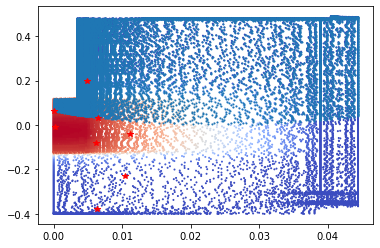

In [41]:
user_const_stg_instance.plot_constraint_on_data(plot_type='contour_map') 
user_const_stg_instance.plot_selected_sensors(sensors = top_sensors_user_stg)
user_const_stg_instance.annotate_sensors(sensors = top_sensors_user_stg)